## NLP CA 5
## Ali Khoramfar - 810102129

## Install Packages

In [1]:
!pip install sentencepiece
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 13.9 MB/s eta 0:00:00 0:00:01


In [ ]:
!rm -rf fairseq
!git clone https://github.com/pytorch/fairseq
!cd fairseq && pip install --editable ./

Cloning into 'fairseq'...
remote: Enumerating objects: 35203, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 35203 (delta 66), reused 81 (delta 49), pack-reused 35083
Receiving objects: 100% (35203/35203), 25.23 MiB | 12.62 MiB/s, done.
Resolving deltas: 100% (25556/25556), done.
Obtaining file:///kaggle/working/fairseq
  Installing build dependencies ... |

In [2]:
#!pip install huggingface-hub
!pip install unbabel-comet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.7/529.7 kB 28.4 MB/s eta 0:00:00
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.2.0
    Uninstalling sentencepiece-0.2.0:
      Successfully uninstalled sentencepiece-0.2.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninsta

In [18]:
import zipfile
import requests
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator
import sentencepiece
from comet import download_model, load_from_checkpoint
import seaborn as sns
#from huggingface_hub import login
from scipy.stats import ttest_ind


# **Data**

## Import Dataset

In [5]:
dataset_url = 'https://object.pouta.csc.fi/OPUS-MIZAN/v1/moses/en-fa.txt.zip'
dataset_zip_path = '/kaggle/working/en-fa.txt.zip'
dataset_extract_path = '/kaggle/working/en-fa/'

In [6]:
response = requests.get(dataset_url)
with open(dataset_zip_path, 'wb') as file:
    file.write(response.content)

In [7]:
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_extract_path)

extracted_files = os.listdir(dataset_extract_path)
extracted_files

['LICENSE', 'README', 'MIZAN.en-fa.fa', 'MIZAN.en-fa.xml', 'MIZAN.en-fa.en']

In [8]:
english_file_path = os.path.join(dataset_extract_path, 'MIZAN.en-fa.en')
persian_file_path = os.path.join(dataset_extract_path, 'MIZAN.en-fa.fa')

## 1. First Lines & Lines Count

In [9]:
def read_first_lines(file_path, num_lines=3):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = [next(file).strip() for _ in range(num_lines)]
    return lines

def count_total_lines(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        total_lines = sum(1 for line in file)
    return total_lines

### English

In [10]:
english_first_lines = read_first_lines(english_file_path)
english_total_lines = count_total_lines(english_file_path)
print("Total number of lines in English file:", english_total_lines)
print("First three lines in English file:")
for line in english_first_lines:
    print(line)

Total number of lines in English file: 1021597
First three lines in English file:
The story which follows was first written out in Paris during the Peace Conference
from notes jotted daily on the march, strengthened by some reports sent to my chiefs in Cairo.
Afterwards, in the autumn of 1919, this first draft and some of the notes were lost.


### Persian

In [11]:
persian_first_lines = read_first_lines(persian_file_path)
persian_total_lines = count_total_lines(persian_file_path)
print("Total number of lines in Persian file:", persian_total_lines)
print("First three lines in Persian file:")
for line in persian_first_lines:
    print(line)

Total number of lines in Persian file: 1021597
First three lines in Persian file:
داستانی که از نظر شما می‌گذرد، ابتدا ضمن کنفرانس صلح پاریس از روی یادداشت‌هائی که به طور روزانه در حال خدمت در صف برداشته شده بودند
و از روی گزارشاتی که برای رؤسای من در قاهره ارسال گردیده بودند نوشته شد.
بعدا در پائیز سال 1919، این نوشته اولیه و بعضی از یادداشت‌ها، مفقود شدند.


### Turn files into Dataframe

In [12]:
english_lines = []
persian_lines = []

with open(english_file_path, 'r', encoding='utf-8') as file:
    english_lines = [line.strip() for line in file]

with open(persian_file_path, 'r', encoding='utf-8') as file:
    persian_lines = [line.strip() for line in file]

data = pd.DataFrame({
    'English': english_lines,
    'Persian': persian_lines
})

In [13]:
data.head()

,English,Persian
0,The story which follows was first written out ...,داستانی که از نظر شما می‌گذرد، ابتدا ضمن کنفرا...
1,"from notes jotted daily on the march, strength...",و از روی گزارشاتی که برای رؤسای من در قاهره ار...
2,"Afterwards, in the autumn of 1919, this first ...",بعدا در پائیز سال 1919، این نوشته اولیه و بعضی...
3,It seemed to me historically needful to reprod...,به نظر من چنان می‌آمد که از نظر تاریخی رخدادها...
4,So it was built again with heavy repugnance in...,لذا این داستان مجددا با تفاوت زیادی، در زمستان...


## 2.Tokenize Lines

### English

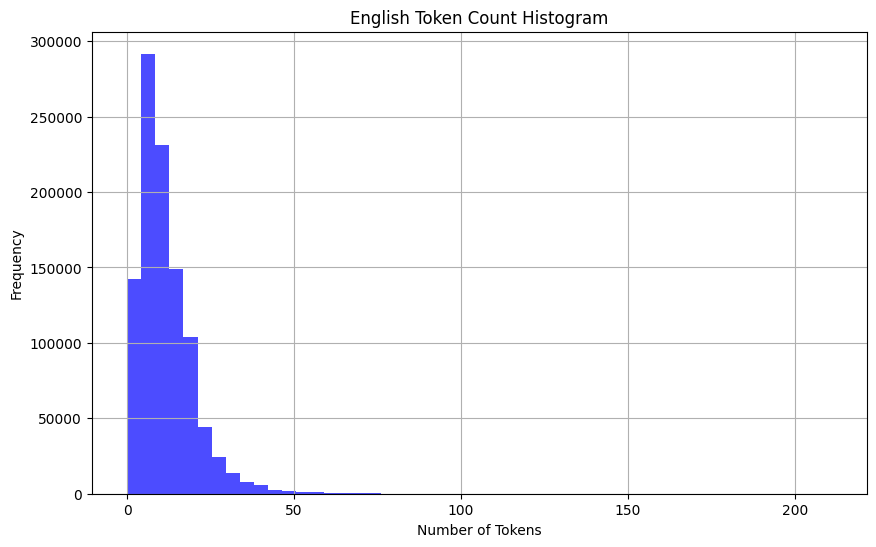

In [14]:
data['English_Tokens'] = data['English'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(data['English_Tokens'], bins=50, color='blue', alpha=0.7)
plt.title('English Token Count Histogram')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Persian

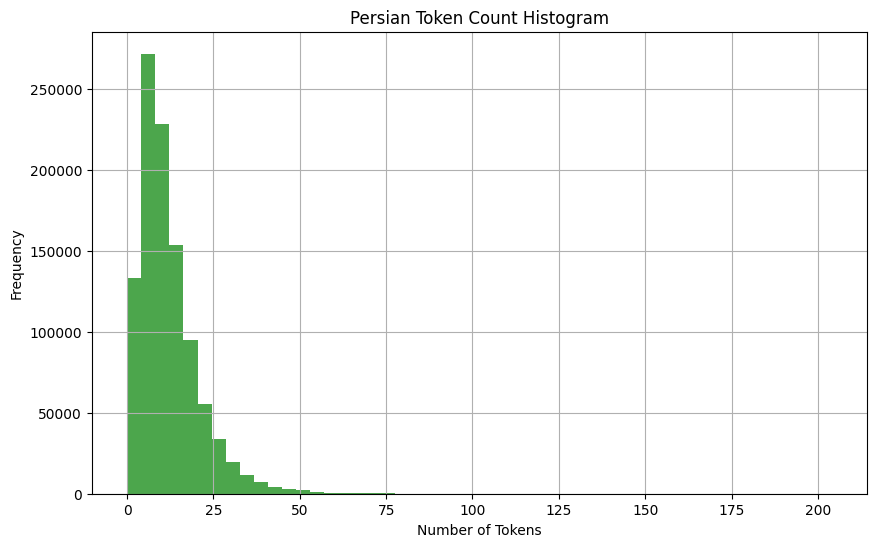

In [15]:
data['Persian_Tokens'] = data['Persian'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(data['Persian_Tokens'], bins=50, color='green', alpha=0.7)
plt.title('Persian Token Count Histogram')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 3. Filter the Dataset

In [16]:
filtered_data = data[(data['Persian_Tokens'] >= 10) & (data['Persian_Tokens'] <= 50)]

original_row_count = len(data)
filtered_row_count = len(filtered_data)

print("Number of rows before filtering:", original_row_count)
print("Number of rows after filtering:", filtered_row_count)

Number of rows before filtering: 1021597
Number of rows after filtering: 548185


In [17]:
filtered_data.head()

,English,Persian,English_Tokens,Persian_Tokens
0,The story which follows was first written out ...,داستانی که از نظر شما می‌گذرد، ابتدا ضمن کنفرا...,14,26
1,"from notes jotted daily on the march, strength...",و از روی گزارشاتی که برای رؤسای من در قاهره ار...,17,15
2,"Afterwards, in the autumn of 1919, this first ...",بعدا در پائیز سال 1919، این نوشته اولیه و بعضی...,16,14
4,So it was built again with heavy repugnance in...,لذا این داستان مجددا با تفاوت زیادی، در زمستان...,22,20
5,The record of events was not dulled in me and ...,من وقایع و رخدادهای اصلی را فراموش نکرده بودم،...,23,17


## 4. Shuffle then Split Dataset

In [18]:
random_seed = 42
shuffled_data = filtered_data.sample(frac=1, random_state=random_seed).reset_index(drop=True)
shuffled_data = shuffled_data.drop(columns=['English_Tokens', 'Persian_Tokens'])

shuffled_data.head()

,English,Persian
0,"Yes, once or twice, when he came into Coombe T...",بله، یک یا دو بار وقتی به کومب تریسی آمده بود.
1,"and yet he scanned with obstinate attention, t...",با این همه، با دقتی لجوجانه، ظلماتی را که در آ...
2,"The next he knew, he was dimly aware that his ...",وقتی به خود آمد، به نحو مبهمی متوجه شد که زبان...
3,Dana drove as fast as she could to Theodore Ro...,دنا با بیشترین سرعتی که می‌توانست به سوی مدرسه...
4,abounds with incidents that fill the hearers w...,مملو از حوادثی است که شنوندگان را مات و مجذوب ...


In [19]:
train_size = 500000
valid_size = 5000
test_size = 10000

train_data = shuffled_data.iloc[:train_size]
valid_data = shuffled_data.iloc[train_size:train_size + valid_size]
test_data = shuffled_data.iloc[train_size + valid_size:train_size + valid_size + test_size]

print("Number of rows in training set:", len(train_data))
print("Number of rows in validation set:", len(valid_data))
print("Number of rows in test set:", len(test_data))

Number of rows in training set: 500000
Number of rows in validation set: 5000
Number of rows in test set: 10000


In [20]:
data['English'][0]

'The story which follows was first written out in Paris during the Peace Conference'

## 5.Save Files

In [21]:
output_dir = '/kaggle/working/raw_data/'
os.makedirs(output_dir, exist_ok=True)

In [22]:
def save_to_file(data, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        for line in data:
            file.write(line.strip() + '\n')

save_to_file(train_data['English'], os.path.join(output_dir, 'train.en'))
save_to_file(train_data['Persian'], os.path.join(output_dir, 'train.fa'))
save_to_file(valid_data['English'], os.path.join(output_dir, 'valid.en'))
save_to_file(valid_data['Persian'], os.path.join(output_dir, 'valid.fa'))
save_to_file(test_data['English'], os.path.join(output_dir, 'test.en'))
save_to_file(test_data['Persian'], os.path.join(output_dir, 'test.fa'))

In [23]:
!wc -l /kaggle/working/raw_data/train.fa

500000 /kaggle/working/raw_data/train.fa


In [27]:
input_dir = '/kaggle/input/nlp-ca5/raw_data'
saved_files = os.listdir(input_dir)
print("Saved files:", saved_files)

Saved files: ['valid.en', 'valid.fa', 'train.fa', 'test.fa', 'test.en', 'train.en']


In [28]:
!wc -l /kaggle/input/nlp-ca5/raw_data/train.fa
!wc -l /kaggle/input/nlp-ca5/raw_data/train.en
!wc -l /kaggle/input/nlp-ca5/raw_data/valid.fa
!wc -l /kaggle/input/nlp-ca5/raw_data/valid.en
!wc -l /kaggle/input/nlp-ca5/raw_data/test.fa
!wc -l /kaggle/input/nlp-ca5/raw_data/test.fa

500000 /kaggle/input/nlp-ca5/raw_data/train.fa
500000 /kaggle/input/nlp-ca5/raw_data/train.en
5000 /kaggle/input/nlp-ca5/raw_data/valid.fa
5000 /kaggle/input/nlp-ca5/raw_data/valid.en
10000 /kaggle/input/nlp-ca5/raw_data/test.fa
10000 /kaggle/input/nlp-ca5/raw_data/test.fa


### Check Saved files in Input

# Part 1 - Train BPE Tokenizers

In [5]:
train_en_file = '/kaggle/input/nlp-ca5/raw_data/train.en'
train_fa_file = '/kaggle/input/nlp-ca5/raw_data/train.fa'

In [6]:
# English
sentencepiece.SentencePieceTrainer.train(input=train_en_file, model_prefix='bpe_en', vocab_size=10000, model_type='bpe')

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /kaggle/input/nlp-ca5/raw_data/train.en
  input_format: 
  model_prefix: bpe_en
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_different

In [7]:
# Farsi
sentencepiece.SentencePieceTrainer.train(input=train_fa_file, model_prefix='bpe_fa', vocab_size=10000, model_type='bpe')

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /kaggle/input/nlp-ca5/raw_data/train.fa
  input_format: 
  model_prefix: bpe_fa
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_different

In [32]:
sp_en = sentencepiece.SentencePieceProcessor(model_file='bpe_en.model')
sp_fa = sentencepiece.SentencePieceProcessor(model_file='bpe_fa.model')

In [35]:
def tokenize_data(input_file, output_file, sp_model):
    with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8') as outfile:
        for line in infile:
            tokenized_line = sp_model.encode(line.strip(), out_type=str)
            outfile.write(' '.join(tokenized_line) + '\n')

output_dir = '/kaggle/working/tokenized_data'
os.makedirs(output_dir, exist_ok=True)

In [36]:
with open('/kaggle/working/tokenized_data/en.vocab', 'w', encoding='utf-8') as vocab_file:
    for i in range(sp_en.get_piece_size()):
        piece = sp_en.id_to_piece(i)
        score = sp_en.get_score(i)
        vocab_file.write(f'{piece}\t{score}\n')

with open('/kaggle/working/tokenized_data/fa.vocab', 'w', encoding='utf-8') as vocab_file:
    for i in range(sp_fa.get_piece_size()):
        piece = sp_fa.id_to_piece(i)
        score = sp_fa.get_score(i)
        vocab_file.write(f'{piece}\t{score}\n')

In [37]:
tokenize_data('/kaggle/input/nlp-ca5/raw_data/train.en', os.path.join(output_dir, 'train.en'), sp_en)
tokenize_data('/kaggle/input/nlp-ca5/raw_data/train.fa', os.path.join(output_dir, 'train.fa'), sp_fa)
tokenize_data('/kaggle/input/nlp-ca5/raw_data/valid.en', os.path.join(output_dir, 'valid.en'), sp_en)
tokenize_data('/kaggle/input/nlp-ca5/raw_data/valid.fa', os.path.join(output_dir, 'valid.fa'), sp_fa)
tokenize_data('/kaggle/input/nlp-ca5/raw_data/test.en', os.path.join(output_dir, 'test.en'), sp_en)
tokenize_data('/kaggle/input/nlp-ca5/raw_data/test.fa', os.path.join(output_dir, 'test.fa'), sp_fa)

In [38]:
tokenized_files = os.listdir(output_dir)
print("Tokenized files:", tokenized_files)

Tokenized files: ['train.fa', 'test.fa', 'en.vocab', 'valid.fa', 'test.en', 'fa.vocab', 'train.en', 'valid.en']


In [40]:
!head /kaggle/input/nlp-ca5/tokenized_data/en.vocab -n 10

<unk>	0.0
<s>	0.0
</s>	0.0
▁t	-0.0
he	-1.0
▁a	-2.0
in	-3.0
▁w	-4.0
▁s	-5.0
▁the	-6.0


In [41]:
print("First 5 lines of tokenized English training data:")
!head /kaggle/input/nlp-ca5/tokenized_data/train.en -n 5

First 5 lines of tokenized English training data:
▁Yes , ▁once ▁or ▁twice , ▁when ▁he ▁came ▁into ▁C oom be ▁Tr ace y .
▁and ▁yet ▁he ▁scan ned ▁with ▁obst inate ▁attention , ▁the ▁darkness ▁in ▁which ▁he ▁walked
▁The ▁next ▁he ▁knew , ▁he ▁was ▁dimly ▁aware ▁that ▁his ▁tongue ▁was ▁hur ting ▁and ▁that ▁he ▁was ▁being ▁j ol ted ▁along ▁in ▁some ▁kind ▁of ▁a ▁con vey ance .
▁Dana ▁drove ▁as ▁fast ▁as ▁she ▁could ▁to ▁The od ore ▁R oose ve lt ▁Middle ▁School , ▁wondering ▁what ▁could ▁have ▁happened .
▁ab ounds ▁with ▁inc idents ▁that ▁fill ▁the ▁he are rs ▁with ▁wonder ▁and ▁astonishment ;


In [42]:
print("First 5 lines of tokenized Farsi training data:")
!head /kaggle/input/nlp-ca5/tokenized_data/train.fa -n 5

First 5 lines of tokenized Farsi training data:
▁بله ، ▁یک ▁یا ▁دو ▁بار ▁وقتی ▁به ▁کو م ب ▁تریسی ▁آمده ▁بود .
▁با ▁این ▁همه ، ▁با ▁د قتی ▁ل جو ج انه ، ▁ظل ماتی ▁را ▁که ▁در ▁آن ▁جای ▁داشت ▁مشاهده ▁می ▁کرد ،
▁وقتی ▁به ▁خود ▁آمد ، ▁به ▁نحو ▁مبهمی ▁متوجه ▁شد ▁که ▁زبانش ▁درد ▁دارد ▁و ▁او ▁را ▁با ▁وسیله ▁ای ▁به ▁سویی ▁می ▁برند ،
▁دنا ▁با ▁بیشترین ▁سرعتی ▁که ▁می ▁توانست ▁به ▁سوی ▁مدرسه ▁راهنمایی ▁تئ ودور ▁روز ولت ▁راند ، ▁در ▁دل ▁از ▁خودش ▁می ▁پرسید ▁چه ▁اتفاقی ▁ممکن ▁است ▁افتاده ▁باشد .
▁مملو ▁از ▁حوادثی ▁است ▁که ▁شنوندگان ▁را ▁مات ▁و ▁مجذوب ▁می ▁کند ،


## Preprocess tokenized data

In [43]:
!fairseq-preprocess --source-lang en --target-lang fa \
    --trainpref /kaggle/input/nlp-ca5/tokenized_data/train \
    --validpref /kaggle/input/nlp-ca5/tokenized_data/valid \
    --testpref /kaggle/input/nlp-ca5/tokenized_data/test \
    --destdir /kaggle/working/fairseq_data \
    --workers 4 \
    --nwordssrc 10000 --nwordstgt 10000

2024-06-10 09:40:10.295414: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 09:40:10.295469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 09:40:10.297055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [44]:
preprocessed_files = os.listdir('/kaggle/working/fairseq_data')
print("Preprocessed files:", preprocessed_files)

Preprocessed files: ['dict.en.txt', 'test.en-fa.fa.bin', 'train.en-fa.fa.idx', 'test.en-fa.en.bin', 'valid.en-fa.fa.bin', 'train.en-fa.fa.bin', 'dict.fa.txt', 'train.en-fa.en.bin', 'valid.en-fa.fa.idx', 'test.en-fa.en.idx', 'preprocess.log', 'valid.en-fa.en.idx', 'test.en-fa.fa.idx', 'valid.en-fa.en.bin', 'train.en-fa.en.idx']


## Load from input

In [46]:
preprocessed_files = os.listdir('/kaggle/input/nlp-ca5/fairseq_data')
print("Preprocessed files:", preprocessed_files)

Preprocessed files: ['test.en-fa.fa.bin', 'valid.en-fa.fa.bin', 'test.en-fa.fa.idx', 'test.en-fa.en.bin', 'preprocess.log', 'dict.en.txt', 'valid.en-fa.en.bin', 'valid.en-fa.fa.idx', 'train.en-fa.fa.idx', 'train.en-fa.en.bin', 'train.en-fa.en.idx', 'valid.en-fa.en.idx', 'dict.fa.txt', 'test.en-fa.en.idx', 'train.en-fa.fa.bin']


# Part2: LSTM ENCODER-DECODER 

## Training the Model


In [47]:
!fairseq-train \
    "/kaggle/input/nlp-ca5/fairseq_data" \
    --arch lstm --share-decoder-input-output-embed \
    --encoder-layers 6 --decoder-layers 6 \
    --optimizer adam --adam-betas '(0.9, 0.98)' --clip-norm 0.1 \
    --lr 2e-3 --lr-scheduler inverse_sqrt --warmup-updates 4000 \
    --dropout 0.3 --weight-decay 0.01 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.2 \
    --max-tokens 8192 --batch-size 128 \
    --update-freq 4 \
    --eval-bleu \
    --eval-bleu-args '{"beam": 5, "max_len_a": 1.2, "max_len_b": 10}' \
    --eval-bleu-detok moses \
    --eval-bleu-print-samples \
    --best-checkpoint-metric bleu --maximize-best-checkpoint-metric \
    --fp16 --memory-efficient-fp16 \
    --max-epoch 5 \
    --num-workers 2 \
    --save-dir /kaggle/working/checkpoints_lstm/ \
    --tensorboard-logdir /kaggle/working/logs_lstm/

2024-06-10 09:47:49.373936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 09:47:49.373992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 09:47:49.375719: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
epoch 001:   0%|                                        | 0/982 [00:00<?, ?it/s]/kaggle/working/fairseq/fairseq/utils.py:374: U

## We Will Run Tensorboard on Colab

In [ ]:
#%load_ext tensorboard
# %tensorboard --logdir "/kaggle/working/logs/" --port=6008

## Fairseq Generate for Test Data

In [48]:
os.makedirs('/kaggle/working/results', exist_ok=True)

In [49]:
!fairseq-generate \
    "/kaggle/input/nlp-ca5/fairseq_data" \
    --batch-size 128 \
    --path "/kaggle/working/checkpoints_lstm/checkpoint_best.pt" \
    --beam 5 \
    --remove-bpe=sentencepiece \
    > "/kaggle/working/results/lstm_eval.txt"

2024-06-10 10:40:09.079433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 10:40:09.079490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 10:40:09.081220: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
  0%|                                                    | 0/79 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


# Part3: Transformer Model

## Training the Model


In [ ]:
!fairseq-train \
    "/kaggle/input/nlp-ca5/fairseq_data" \
    --arch transformer --share-decoder-input-output-embed \
    --encoder-layers 6 --decoder-layers 6 \
    --optimizer adam --adam-betas '(0.9, 0.98)' --clip-norm 0.1 \
    --lr 1e-3 --lr-scheduler inverse_sqrt --warmup-updates 4000 \
    --dropout 0.3 --weight-decay 0.01 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.2 \
    --max-tokens 8192 --batch-size 128 \
    --update-freq 4 \
    --eval-bleu \
    --eval-bleu-args '{"beam": 5, "max_len_a": 1.2, "max_len_b": 10}' \
    --eval-bleu-detok moses \
    --eval-bleu-print-samples \
    --best-checkpoint-metric bleu --maximize-best-checkpoint-metric \
    --fp16 --memory-efficient-fp16 \
    --max-epoch 10 \
    --num-workers 2 \
    --save-dir /kaggle/working/checkpoints_transformer/ \
    --tensorboard-logdir /kaggle/working/logs_transformer/

2024-06-10 10:43:43.479253: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 10:43:43.479311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 10:43:43.480971: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
epoch 001:   0%|                                        | 0/982 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/n

## We Will Run Tensorboard on Colab

In [ ]:
#%load_ext tensorboard
# %tensorboard --logdir "/kaggle/working/logs/" --port=6008

## Fairseq Generate for Test Data

In [ ]:
os.makedirs('/kaggle/working/results', exist_ok=True)

In [52]:
!fairseq-generate \
    "/kaggle/input/nlp-ca5/fairseq_data" \
    --batch-size 128 \
    --path "/kaggle/working/checkpoints_transformer/checkpoint_best.pt" \
    --beam 5 \
    --remove-bpe=sentencepiece \
    > "/kaggle/working/results/transformer_eval.txt"

2024-06-10 11:47:25.100114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 11:47:25.100178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 11:47:25.102056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
  0%|                                                    | 0/79 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [53]:
!zip -r /kaggle/working/logs_lstm.zip /kaggle/working/logs_lstm/
!zip -r /kaggle/working/logs_transformer.zip /kaggle/working/logs_transformer/

  adding: kaggle/working/logs_lstm/ (stored 0%)
  adding: kaggle/working/logs_lstm/train_inner/ (stored 0%)
  adding: kaggle/working/logs_lstm/train_inner/events.out.tfevents.1718012959.cde65a9f78b1.495.0 (deflated 66%)
  adding: kaggle/working/logs_lstm/valid/ (stored 0%)
  adding: kaggle/working/logs_lstm/valid/events.out.tfevents.1718013506.cde65a9f78b1.495.1 (deflated 50%)
  adding: kaggle/working/logs_lstm/train/ (stored 0%)
  adding: kaggle/working/logs_lstm/train/events.out.tfevents.1718013507.cde65a9f78b1.495.2 (deflated 54%)
  adding: kaggle/working/logs_transformer/ (stored 0%)
  adding: kaggle/working/logs_transformer/train_inner/ (stored 0%)
  adding: kaggle/working/logs_transformer/train_inner/events.out.tfevents.1718016321.cde65a9f78b1.628.0 (deflated 66%)
  adding: kaggle/working/logs_transformer/valid/ (stored 0%)
  adding: kaggle/working/logs_transformer/valid/events.out.tfevents.1718016950.cde65a9f78b1.628.1 (deflated 51%)
  adding: kaggle/working/logs_transformer/tra

# Part4: Validating Test Data

In [5]:
sp_en = sentencepiece.SentencePieceProcessor(model_file='/kaggle/input/nlp-ca5/bpe_en.model')
sp_fa = sentencepiece.SentencePieceProcessor(model_file='/kaggle/input/nlp-ca5/bpe_fa.model')

In [6]:
def decode_sentence(sentence, sp_model):
    decoded_sentence = sp_model.decode(sentence.strip())
    return decoded_sentence.strip()

In [7]:
fairseq_generate_output_lstm = '/kaggle/input/fairseq-generate-output/lstm_eval.txt'
fairseq_generate_output_transformer = '/kaggle/input/fairseq-generate-output/transformer_eval.txt'

In [8]:
def extract_and_decode_sentences(file_path, sp_en, sp_fa):
    source_sentences = []
    target_sentences = []
    mt_sentences = []
    
    with open(file_path, 'r', encoding='utf-8') as infile:
        for line in infile:
            if line.startswith('S-'):
                decoded_sentence = decode_sentence(line.split('\t')[1], sp_en)
                source_sentences.append(decoded_sentence)
            elif line.startswith('T-'):
                decoded_sentence = decode_sentence(line.split('\t')[1], sp_fa)
                target_sentences.append(decoded_sentence)
            elif line.startswith('H-'):
                decoded_sentence = decode_sentence(line.split('\t')[2], sp_fa)
                mt_sentences.append(decoded_sentence)
    
    return source_sentences, target_sentences, mt_sentences

source_lstm, target_lstm, mt_lstm = extract_and_decode_sentences(fairseq_generate_output_lstm, sp_en, sp_fa)
source_transformer, target_transformer, mt_transformer = extract_and_decode_sentences(fairseq_generate_output_transformer, sp_en, sp_fa)

In [39]:
login(token="")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
model_path = download_model("Unbabel/wmt22-comet-da")
model = load_from_checkpoint(model_path)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model.ckpt:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

hparams.yaml:   0%|          | 0.00/567 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/9.69k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.53k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [9]:
data_lstm = [{"src": src, "mt": mt, "ref": ref} for src, mt, ref in zip(source_lstm, mt_lstm, target_lstm)]
data_transformer = [{"src": src, "mt": mt, "ref": ref} for src, mt, ref in zip(source_transformer, mt_transformer, target_transformer)]

In [10]:
data_lstm[5]

{'src': 'replied the girl, shaking her head.',
 'mt': 'دخترک درحالی که سرش را تکان می داد جواب داد:',
 'ref': 'دختر در حالی که سر خود را تکان می داد گفت:'}

In [11]:
results_lstm_comet = model.predict(data_lstm, batch_size=8, gpus=1)

Predicting DataLoader 0: 100%|██████████| 1250/1250 [02:31<00:00,  8.24it/s]


In [12]:
print(results_lstm_comet.system_score) # system-level score

0.5012778256580234


In [13]:
results_transformer_comet = model.predict(data_transformer, batch_size=8, gpus=1)

Predicting DataLoader 0: 100%|██████████| 1250/1250 [02:22<00:00,  8.78it/s]


In [16]:
print(results_transformer_comet.system_score) # system-level score

0.5736673649847508


In [17]:
lstm_scores_df = pd.DataFrame(results_lstm_comet)
transformer_scores_df = pd.DataFrame(results_transformer_comet)

In [27]:
mean_lstm_comet = lstm_scores_df['scores'].mean()
std_lstm_comet = lstm_scores_df['scores'].std()
mean_transformer_comet = transformer_scores_df['scores'].mean()
std_transformer_comet = transformer_scores_df['scores'].std()

In [28]:
print(f"LSTM Model COMET Scores (Mean ± Std): {mean_lstm_comet:.4f} ± {std_lstm_comet:.4f}")
print(f"Transformer Model COMET Scores (Mean ± Std): {mean_transformer_comet:.4f} ± {std_transformer_comet:.4f}")

LSTM Model COMET Scores (Mean ± Std): 0.5013 ± 0.1190
Transformer Model COMET Scores (Mean ± Std): 0.5737 ± 0.1314


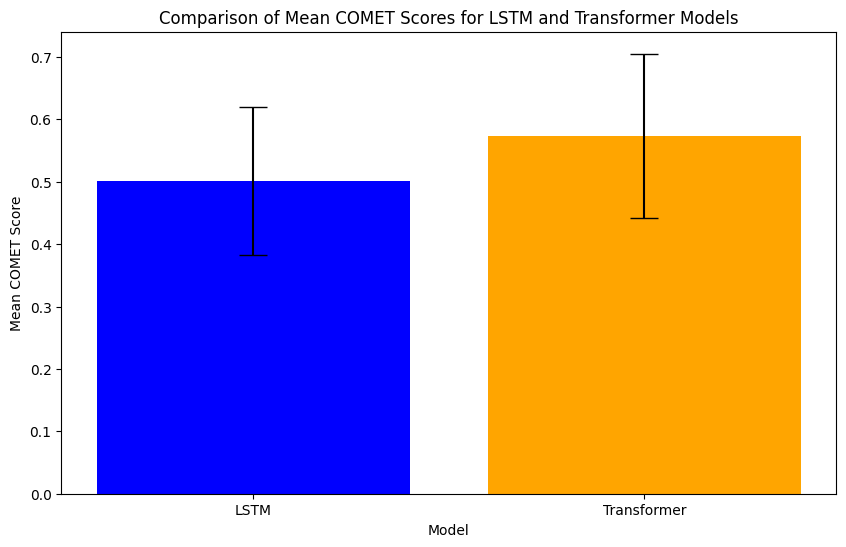

In [37]:
models = ['LSTM', 'Transformer']
mean_scores = [mean_lstm_comet, mean_transformer_comet]
std_devs = [std_lstm_comet, std_transformer_comet]

plt.figure(figsize=(10, 6))
plt.bar(models, mean_scores, yerr=std_devs, capsize=10, color=['blue', 'orange'])
plt.xlabel('Model')
plt.ylabel('Mean COMET Score')
plt.title('Comparison of Mean COMET Scores for LSTM and Transformer Models')
plt.show()

In [31]:
lstm_scores_df['Model'] = 'LSTM'
transformer_scores_df['Model'] = 'Transformer'

combined_df = pd.concat([lstm_scores_df, transformer_scores_df])

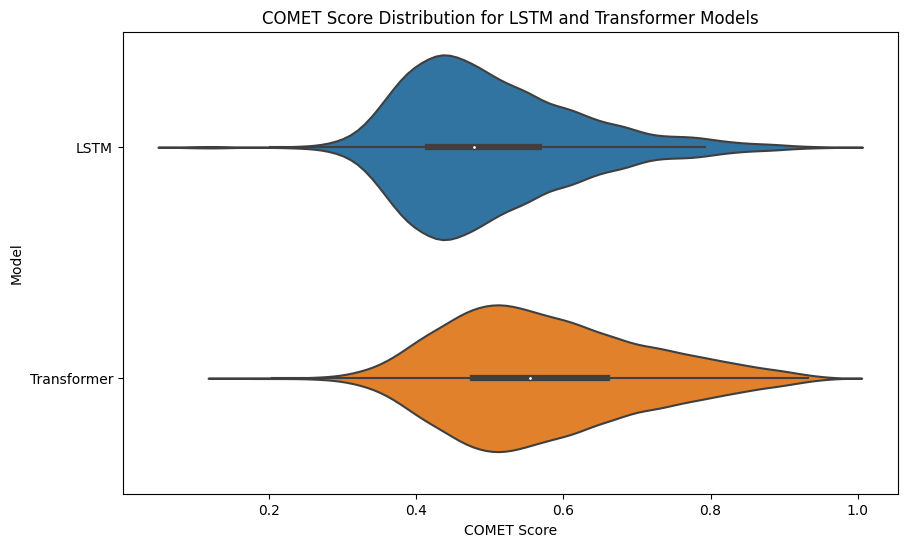

In [38]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='scores', y='Model', data=combined_df)
plt.title('COMET Score Distribution for LSTM and Transformer Models')
plt.xlabel('COMET Score')
plt.ylabel('Model')
plt.show()

In [ ]:
t_stat, p_value = ttest_ind(transformer_scores, lstm_scores, alternative='greater')

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")